In [13]:
import pandas as pd 
import pandas as pd 
from sklearn import preprocessing 
import networkx as nx
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from modularity_maximization import partition
from modularity_maximization.utils import get_modularity
from modutils import mod_calc
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
device = torch.device('cpu')
dataset  = 'wheat_seeds.csv'
myFile = pd.read_csv(dataset, sep=',')
data = myFile.iloc[:, 0:len(myFile.columns)-1]

In [14]:
import numpy as np
labels = []
my_data = np.genfromtxt(dataset, delimiter=',')
for column in my_data.T[len(myFile.columns) - 1]:
    if(column != len(myFile.columns)):
        labels.append(int(column))
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [15]:
# Normalize the data attributes for the Iris dataset.
from sklearn.datasets import load_iris
from sklearn import preprocessing
# separate the data from the target attributes
X = data.values[:,0:len(myFile.columns) - 1]
print(X)
y = labels
# normalize the data attributes
normalized_X = preprocessing.scale(X)
print(normalized_X.shape)

[[15.26   14.84    0.871   5.763   3.312   2.221   5.22  ]
 [14.88   14.57    0.8811  5.554   3.333   1.018   4.956 ]
 [14.29   14.09    0.905   5.291   3.337   2.699   4.825 ]
 [13.84   13.94    0.8955  5.324   3.379   2.259   4.805 ]
 [16.14   14.99    0.9034  5.658   3.562   1.355   5.175 ]
 [14.38   14.21    0.8951  5.386   3.312   2.462   4.956 ]
 [14.69   14.49    0.8799  5.563   3.259   3.586   5.219 ]
 [14.11   14.1     0.8911  5.42    3.302   2.7     5.    ]
 [16.63   15.46    0.8747  6.053   3.465   2.04    5.877 ]
 [16.44   15.25    0.888   5.884   3.505   1.969   5.533 ]
 [15.26   14.85    0.8696  5.714   3.242   4.543   5.314 ]
 [14.03   14.16    0.8796  5.438   3.201   1.717   5.001 ]
 [13.89   14.02    0.888   5.439   3.199   3.986   4.738 ]
 [13.78   14.06    0.8759  5.479   3.156   3.136   4.872 ]
 [13.74   14.05    0.8744  5.482   3.114   2.932   4.825 ]
 [14.59   14.28    0.8993  5.351   3.333   4.185   4.781 ]
 [13.99   13.83    0.9183  5.119   3.383   5.234   4.781

In [16]:
X = normalized_X

from scipy.spatial.distance import pdist,squareform
mat = squareform(pdist(normalized_X, metric='euclidean'))
A_hat = numpy.reciprocal(mat, where= mat > 0.0, out = np.zeros_like(mat))

print(A_hat.shape)

(210, 210)


In [17]:
CLASS = 3

In [18]:
class CDCGS(nn.Module):
  def __init__(self, A_hat, num_feat, num_hidden, CLASS):
    super(CDCGS, self).__init__()
    self.num_feat = num_feat
    self.num_hidden = num_hidden
    self.A_hat = A_hat
    self.W_0 = nn.Parameter(torch.ones(num_feat, CLASS))
    print(self.W_0.size())
    self.W_1 = nn.Parameter(torch.ones(num_feat, num_hidden))
    I = F.one_hot(torch.tensor(random.sample(range(0, num_feat), num_feat)), num_classes=num_feat)
    self.I = torch.tensor(I,dtype=torch.float)

  def forward(self, X, A_hat,temp):
    global featureSelector
    global weight_feature
    featureSelector = self.W_0
    results = torch.zeros(self.W_0.size())
    x = 10
    for i in range(x):
        results += F.gumbel_softmax(self.W_0,tau=temp,hard=False)
    weight_feature = results/x

    #H = torch.mm(X_tensor,self.W_1.T)
    H = torch.mm(torch.mm(weight_feature.T,X_tensor),weight_feature)
    H = torch.div(H, H.sum(axis=0))
    m = nn.Softmax(dim=0)
    return m(H)

num_hidden = len(A_hat[0])

model = CDCGS(A_hat, len(A_hat), num_hidden, CLASS).to(device)

def lossFn(output,exp): 
    return torch.sum((torch.diag(-torch.log(output))))

optimizer = optim.Adam(model.parameters(), lr=5e-2, weight_decay=0, betas=(0.5, 0.999), eps=1e-08)

X_tensor = torch.Tensor(A_hat).to(device)

loss_hist = []
acc_hist = []
temp = 1

for epoch in range(300):
    model.train()
    model.zero_grad()
    if(epoch == 75):
        temp = 0.75
    elif(epoch == 150):
        temp = 0.01
    output = model(X_tensor, 0, temp)
    loss = lossFn(output,torch.diag(torch.ones(output.size()[0])))/CLASS
    loss_hist.append(loss.item())
    print('loss',epoch,loss)
    loss.backward()
    optimizer.step()


torch.Size([210, 3])
loss 0 tensor(1.0988, grad_fn=<DivBackward0>)


/opt/anaconda/envs/Deepak/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


loss 1 tensor(1.0986, grad_fn=<DivBackward0>)
loss 2 tensor(1.0985, grad_fn=<DivBackward0>)
loss 3 tensor(1.0980, grad_fn=<DivBackward0>)
loss 4 tensor(1.0982, grad_fn=<DivBackward0>)
loss 5 tensor(1.0968, grad_fn=<DivBackward0>)
loss 6 tensor(1.0956, grad_fn=<DivBackward0>)
loss 7 tensor(1.0924, grad_fn=<DivBackward0>)
loss 8 tensor(1.0921, grad_fn=<DivBackward0>)
loss 9 tensor(1.0876, grad_fn=<DivBackward0>)
loss 10 tensor(1.0862, grad_fn=<DivBackward0>)
loss 11 tensor(1.0804, grad_fn=<DivBackward0>)
loss 12 tensor(1.0764, grad_fn=<DivBackward0>)
loss 13 tensor(1.0726, grad_fn=<DivBackward0>)
loss 14 tensor(1.0646, grad_fn=<DivBackward0>)
loss 15 tensor(1.0591, grad_fn=<DivBackward0>)
loss 16 tensor(1.0537, grad_fn=<DivBackward0>)
loss 17 tensor(1.0480, grad_fn=<DivBackward0>)
loss 18 tensor(1.0388, grad_fn=<DivBackward0>)
loss 19 tensor(1.0307, grad_fn=<DivBackward0>)
loss 20 tensor(1.0257, grad_fn=<DivBackward0>)
loss 21 tensor(1.0184, grad_fn=<DivBackward0>)
loss 22 tensor(1.0123,

loss 175 tensor(0.9095, grad_fn=<DivBackward0>)
loss 176 tensor(0.9112, grad_fn=<DivBackward0>)
loss 177 tensor(0.9098, grad_fn=<DivBackward0>)
loss 178 tensor(0.9098, grad_fn=<DivBackward0>)
loss 179 tensor(0.9099, grad_fn=<DivBackward0>)
loss 180 tensor(0.9097, grad_fn=<DivBackward0>)
loss 181 tensor(0.9099, grad_fn=<DivBackward0>)
loss 182 tensor(0.9096, grad_fn=<DivBackward0>)
loss 183 tensor(0.9102, grad_fn=<DivBackward0>)
loss 184 tensor(0.9097, grad_fn=<DivBackward0>)
loss 185 tensor(0.9098, grad_fn=<DivBackward0>)
loss 186 tensor(0.9089, grad_fn=<DivBackward0>)
loss 187 tensor(0.9089, grad_fn=<DivBackward0>)
loss 188 tensor(0.9101, grad_fn=<DivBackward0>)
loss 189 tensor(0.9098, grad_fn=<DivBackward0>)
loss 190 tensor(0.9089, grad_fn=<DivBackward0>)
loss 191 tensor(0.9089, grad_fn=<DivBackward0>)
loss 192 tensor(0.9098, grad_fn=<DivBackward0>)
loss 193 tensor(0.9092, grad_fn=<DivBackward0>)
loss 194 tensor(0.9092, grad_fn=<DivBackward0>)
loss 195 tensor(0.9097, grad_fn=<DivBack

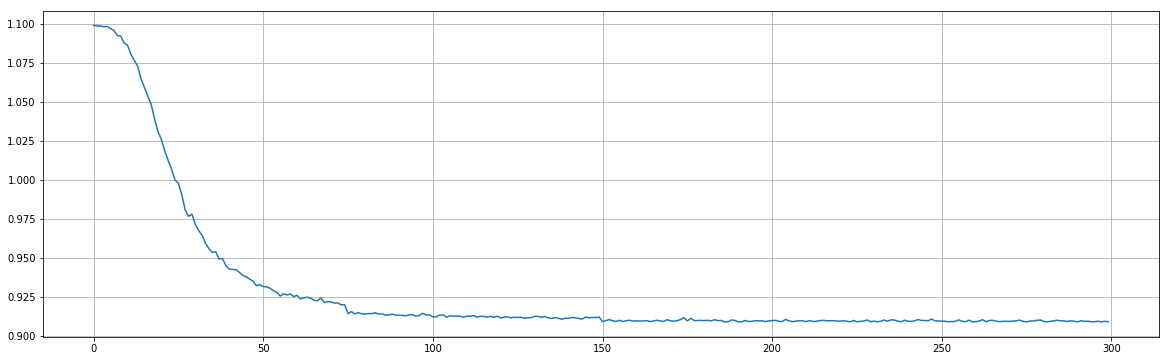

In [19]:
plt.figure(figsize=(20, 6))
plt.plot(loss_hist)
plt.grid(True)
plt.show()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


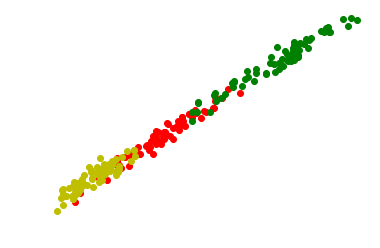

In [107]:
import matplotlib.pyplot as pyplot
labels_true = np.array(y)
print(labels_true)

clusters = numpy.unique(labels_true)
color = ['r','g','y']
pltObj = []
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = numpy.where(labels_true == cluster)
    # create scatter of these samples
    #pyplot.scatter(X[row_ix, 0], X[row_ix, 1],color=color[cluster])
    pltObj.append(pyplot.scatter(X[row_ix, 0], X[row_ix, 1],color=color[cluster]))
# show the plot
'''plt.legend((pltObj[1], pltObj[0], pltObj[2]),
           ('Class 0', 'Class 1', 'Class 2'),
           scatterpoints=1,
           loc='lower right',
           ncol=1,
           fontsize=8)'''
plt.axis('off')
pyplot.show()


[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 0 2 0 0 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1]


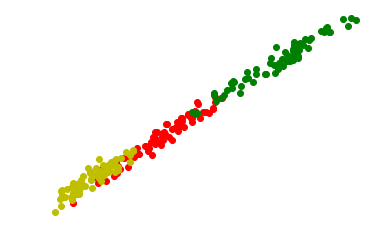

------------------------------------------------------
Data Points Clustering via Gumbel softmax
------------------------------------------------------
adjusted_rand_score 0.7850058137442929
normalized_mutual_info_score 0.7359972239050516
homogeneity_score 0.7359291819878871
completeness_score 0.7360652784053033
v_measure_score 0.7359972239050516


In [108]:
import matplotlib.pyplot as pyplot
gumbel_matrix = weight_feature.detach().max(dim=1)[1]
print(gumbel_matrix.numpy())
labels_true = y
#print(y)
labels_pred = gumbel_matrix.data.numpy()
from modularity_maximization import partition
from modularity_maximization.utils import get_modularity
from sklearn import metrics
from sklearn.metrics.cluster import normalized_mutual_info_score,adjusted_rand_score
clusters = numpy.unique(labels_pred)

color = ['r','y','g']
pltObj = []
for cluster in clusters:
    # get row indexes forlabels_predth this cluster
    row_ix = numpy.where(labels_pred == cluster)
    # create scatter of these samples
    #pyplot.scatter(X[row_ix, 0], X[row_ix, 1],color=color[cluster])
    pltObj.append(pyplot.scatter(X[row_ix, 0], X[row_ix, 1],color=color[cluster]))
# show the plot

plt.axis('off')
pyplot.show()

print('------------------------------------------------------')
print('Data Points Clustering via Gumbel softmax')
print('------------------------------------------------------')
print('adjusted_rand_score',adjusted_rand_score(labels_true, labels_pred))
print('normalized_mutual_info_score',normalized_mutual_info_score(labels_true, labels_pred))
print('homogeneity_score',metrics.homogeneity_score(labels_true, labels_pred))
print('completeness_score',metrics.completeness_score(labels_true, labels_pred))
print('v_measure_score',metrics.v_measure_score(labels_true, labels_pred))

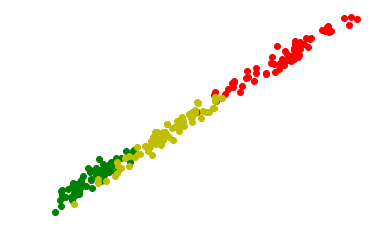

------------------
Spectral Clustering
------------------
adjusted_rand_score 0.7606664262076659
normalized_mutual_info_score 0.7169831330189942
homogeneity_score 0.7167141060881306
completeness_score 0.7172523619904375
v_measure_score 0.7169831330189942


In [111]:
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import AffinityPropagation,SpectralClustering, AgglomerativeClustering, OPTICS, Birch, DBSCAN, KMeans, MiniBatchKMeans, MeanShift
Num_class = CLASS
from numpy import where
from sklearn.datasets import make_classification, make_moons, make_gaussian_quantiles
from matplotlib import pyplot

model = SpectralClustering(n_clusters=Num_class)
# fit the model
model.fit(X)
# assign a cluster to each example
labels_pred = model.fit_predict(X)
# retrieve unique clusters
clusters = unique(labels_pred)
# create scatter plot for samples from each cluster
color = ['r','g','y']
pltObj = []
for cluster in clusters:
    # get row indexes forlabels_predth this cluster
    row_ix = numpy.where(labels_pred == cluster)
    # create scatter of these samples
    #pyplot.scatter(X[row_ix, 0], X[row_ix, 1],color=color[cluster])
    pltObj.append(pyplot.scatter(X[row_ix, 0], X[row_ix, 1],color=color[cluster]))
# show the plot

plt.axis('off')
pyplot.show()

print('------------------')
print('Spectral Clustering')
print('------------------')
print('adjusted_rand_score',adjusted_rand_score(labels_true, labels_pred))
print('normalized_mutual_info_score',normalized_mutual_info_score(labels_true, labels_pred))
print('homogeneity_score',metrics.homogeneity_score(labels_true, labels_pred))
print('completeness_score',metrics.completeness_score(labels_true, labels_pred))
print('v_measure_score',metrics.v_measure_score(labels_true, labels_pred))

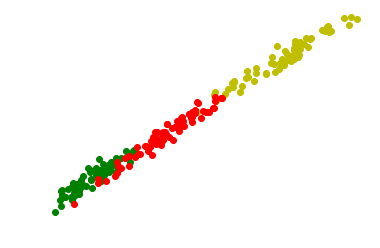

------------------
Birch
------------------
adjusted_rand_score 0.7969982835930121
normalized_mutual_info_score 0.7498157518928459
homogeneity_score 0.7496067557308285
completeness_score 0.7500248646268578
v_measure_score 0.7498157518928459


In [112]:
model = Birch(threshold=0.01, n_clusters=Num_class)
# fit the model
model.fit(X)
# assign a cluster to each example
labels_pred_birch = model.predict(X)
# retrieve unique clusters
clusters = unique(labels_pred)
# create scatter plot for samples from each cluster
color = ['y','g','r']
pltObj = []
for cluster in clusters:
    # get row indexes forlabels_predth this cluster
    row_ix = numpy.where(labels_pred == cluster)
    # create scatter of these samples
    #pyplot.scatter(X[row_ix, 0], X[row_ix, 1],color=color[cluster])
    pltObj.append(pyplot.scatter(X[row_ix, 0], X[row_ix, 1],color=color[cluster]))
# show the plot
plt.axis('off')
pyplot.show()
print('------------------')
print('Birch')
print('------------------')
print('adjusted_rand_score',adjusted_rand_score(labels_true, labels_pred_birch))
print('normalized_mutual_info_score',normalized_mutual_info_score(labels_true, labels_pred_birch))
print('homogeneity_score',metrics.homogeneity_score(labels_true, labels_pred_birch))
print('completeness_score',metrics.completeness_score(labels_true, labels_pred_birch))
print('v_measure_score',metrics.v_measure_score(labels_true, labels_pred_birch))

------------------
Agglomerative Clustering
------------------
adjusted_rand_score 0.7969982835930121
normalized_mutual_info_score 0.7498157518928459
homogeneity_score 0.7496067557308285
completeness_score 0.7500248646268578
v_measure_score 0.7498157518928459


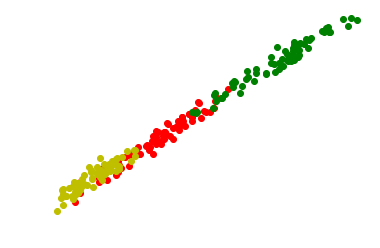

In [113]:
model = AgglomerativeClustering(n_clusters=Num_class)
# fit model and predict clusters
labels_pred = model.fit_predict(X)
# retrieve unique clusters
clusters = unique(labels_pred)
# create scatter plot for samples from each cluster
color = ['r','g','y']
pltObj = []
for cluster in clusters:
    # get row indexes forlabels_predth this cluster
    row_ix = numpy.where(labels_pred == cluster)
    # create scatter of these samples
    #pyplot.scatter(X[row_ix, 0], X[row_ix, 1],color=color[cluster])
    pltObj.append(pyplot.scatter(X[row_ix, 0], X[row_ix, 1],color=color[cluster]))
# show the plot
'''plt.legend((pltObj[2], pltObj[0], pltObj[1]),
           ('Class 0', 'Class 1', 'Class 2'),
           scatterpoints=1,
           loc='lower right',
           ncol=1,
           fontsize=8)
plt.axis('off')
pyplot.show()'''
plt.axis('off')
print('------------------')
print('Agglomerative Clustering')
print('------------------')
print('adjusted_rand_score',adjusted_rand_score(labels_true, labels_pred))
print('normalized_mutual_info_score',normalized_mutual_info_score(labels_true, labels_pred))
print('homogeneity_score',metrics.homogeneity_score(labels_true, labels_pred))
print('completeness_score',metrics.completeness_score(labels_true, labels_pred))
print('v_measure_score',metrics.v_measure_score(labels_true, labels_pred))

------------------
K Means
------------------
adjusted_rand_score 0.7732937360806309
normalized_mutual_info_score 0.7278641446984669
homogeneity_score 0.7277053952805548
completeness_score 0.728022963394075
v_measure_score 0.727864144698467


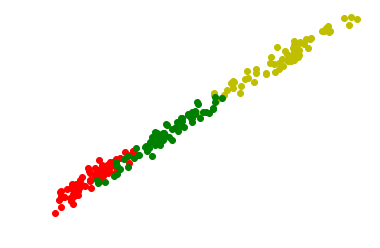

In [114]:
model = KMeans(n_clusters=Num_class)
# fit the model
model.fit(X)
# assign a cluster to each example
labels_pred = model.predict(X)
# retrieve unique clusters
clusters = unique(labels_pred)
# create scatter plot for samples from each cluster
color = ['r','y','g']
pltObj = []
for cluster in clusters:
    # get row indexes forlabels_predth this cluster
    row_ix = numpy.where(labels_pred == cluster)
    # create scatter of these samples
    #pyplot.scatter(X[row_ix, 0], X[row_ix, 1],color=color[cluster])
    pltObj.append(pyplot.scatter(X[row_ix, 0], X[row_ix, 1],color=color[cluster]))
# show the plot
'''plt.legend((pltObj[2], pltObj[0], pltObj[1]),
           ('Class 0', 'Class 1', 'Class 2'),
           scatterpoints=1,
           loc='lower right',
           ncol=1,
           fontsize=8)
plt.axis('off')
pyplot.show()'''
plt.axis('off')
print('------------------')
print('K Means')
print('------------------')
print('adjusted_rand_score',adjusted_rand_score(labels_true, labels_pred))
print('normalized_mutual_info_score',normalized_mutual_info_score(labels_true, labels_pred))
print('homogeneity_score',metrics.homogeneity_score(labels_true, labels_pred))
print('completeness_score',metrics.completeness_score(labels_true, labels_pred))
print('v_measure_score',metrics.v_measure_score(labels_true, labels_pred))

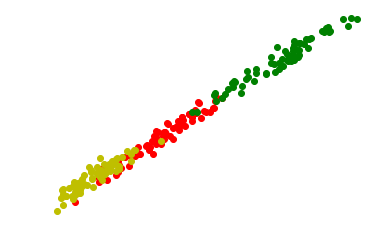

------------------
MiniBatch K-Means
------------------
adjusted_rand_score 0.7853223742707814
normalized_mutual_info_score 0.7385258776172148
homogeneity_score 0.7384344045948831
completeness_score 0.7386173733046617
v_measure_score 0.7385258776172149


In [83]:
model = MiniBatchKMeans(n_clusters=Num_class)
# fit the model
model.fit(X)
# assign a cluster to each example
labels_pred = model.predict(X)
# retrieve unique clusters
clusters = unique(labels_pred)
# create scatter plot for samples from each cluster
color = ['r','g','y']
pltObj = []
for cluster in clusters:
    # get row indexes forlabels_predth this cluster
    row_ix = numpy.where(labels_pred == cluster)
    # create scatter of these samples
    #pyplot.scatter(X[row_ix, 0], X[row_ix, 1],color=color[cluster])
    pltObj.append(pyplot.scatter(X[row_ix, 0], X[row_ix, 1],color=color[cluster]))
# show the plot

plt.axis('off')
pyplot.show()
print('------------------')
print('MiniBatch K-Means')
print('------------------')
print('adjusted_rand_score',adjusted_rand_score(labels_true, labels_pred))
print('normalized_mutual_info_score',normalized_mutual_info_score(labels_true, labels_pred))
print('homogeneity_score',metrics.homogeneity_score(labels_true, labels_pred))
print('completeness_score',metrics.completeness_score(labels_true, labels_pred))
print('v_measure_score',metrics.v_measure_score(labels_true, labels_pred))

[ 0  1  2  3  4  5  6  7  8  9 10]


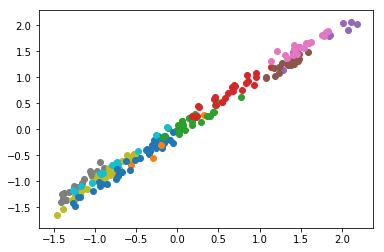

------------------
Affinity Propagation
------------------
adjusted_rand_score 0.298717044973918
normalized_mutual_info_score 0.5187607531738472
homogeneity_score 0.8091221874769637
completeness_score 0.38176178987155246
v_measure_score 0.5187607531738472


In [109]:
model = AffinityPropagation(damping=0.9)
# fit the model
model.fit(X)
# assign a cluster to each example
labels_pred = model.predict(X)
# retrieve unique clusters
clusters = unique(labels_pred)
print(clusters)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(labels_pred == cluster)
    # create scatter of these samples
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()
print('------------------')
print('Affinity Propagation')
print('------------------')
print('adjusted_rand_score',adjusted_rand_score(labels_true, labels_pred))
print('normalized_mutual_info_score',normalized_mutual_info_score(labels_true, labels_pred))
print('homogeneity_score',metrics.homogeneity_score(labels_true, labels_pred))
print('completeness_score',metrics.completeness_score(labels_true, labels_pred))
print('v_measure_score',metrics.v_measure_score(labels_true, labels_pred))